# Imports

In [95]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from typing import Callable

# Gerar a Imagem

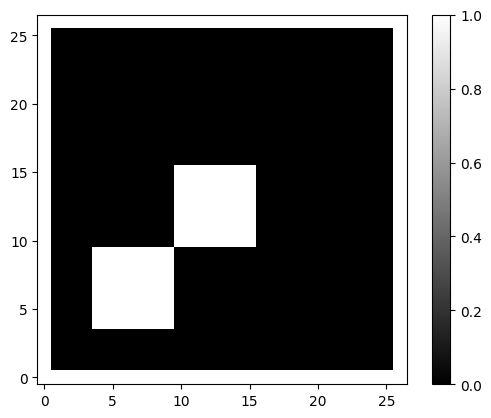

In [96]:
# Tamanho da imagem (quadrada)
Nimg = 27

# Gerar a imagem
ff = np.zeros((Nimg, Nimg))
ff[Nimg//2 - 3: Nimg//2 + 3, Nimg//2 - 3: Nimg//2 + 3] = 1
ff[Nimg//2 - 9: Nimg//2 - 3, Nimg//2 - 9: Nimg//2 - 3] = 1

ff[0] = 1
ff[-1] = 1
ff[:, 0] = 1
ff[:, -1] = 1

# Ver a imagem
plt.imshow(ff, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

# Sinograma

Vamos obter o sinograma fazendo a transformada de Radon. Vamos seguir os seguintes passos:
1. Fazer um novo array que contenha a imagem anterior dentro de um disco com centro no centro do novo array. Deste modo ao rodarmos o array devemos obter o mesmo número de pontos na projeção, independentemente do ângulo de rotação.

2. Rodar o array para o $\alpha$ ângulo desejado.

3. Somar os items ao longo de cada coluna, obtendo o valor de $p(s, \alpha)$.

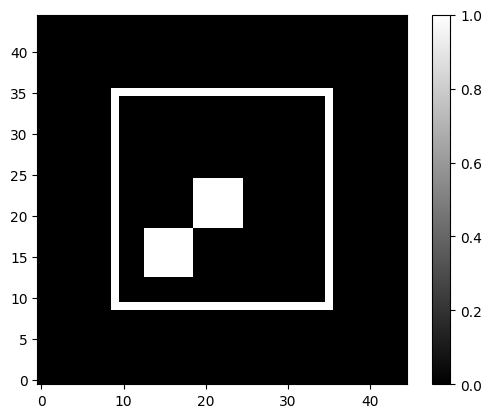

In [97]:
def imgContainer(img: np.ndarray, margin = 3) -> np.ndarray:
    """
        Devolve um array que contém no centro a imagem img, tal que qualquer rotação do array devolvido (sem alteração da fronteira) preserva a imagem img no seu centro.
    """

    # Tamanho da imagem
    N = img.shape[0]

    # Se a imagem tiver um tamanho par, adicionar padding à volta para que tenha tamanho ímpar (com tamanho ímpar há um pixel central!)
    par = 1 if N % 2 == 0 else 0
    N += par

    # Tamanho do contentor (a margem permite que a interpolação feita na rotação fique também dentro dos limites)
    Nc = int(2**(0.5) * N) + 2 * margin
    Nc += 1 if Nc % 2 == 0 else 0

    # Margem entre a imagem e a fronteira
    Nd = (Nc - N)//2

    # Contentor
    imgCont = np.zeros((Nc, Nc))

    # Guardar a imagem no centro do contentor
    imgCont[Nd: Nc-Nd-par, Nd: Nc-Nd-par] = img

    return imgCont


imgCont = imgContainer(ff)

# Ver a imagem
plt.imshow(imgCont, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

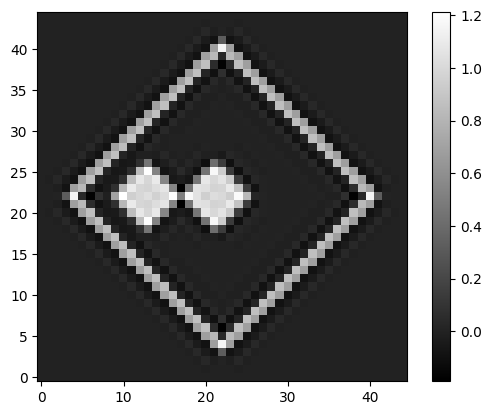

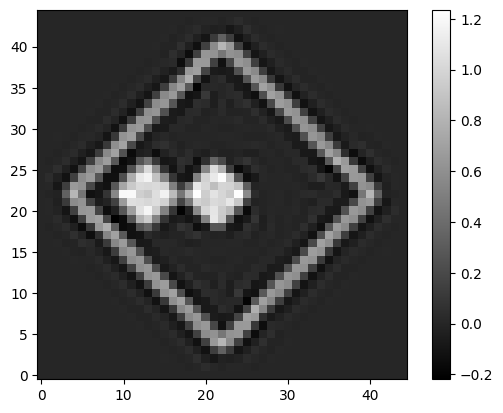

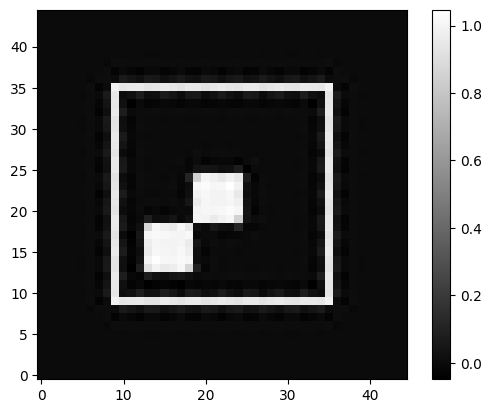

In [98]:
# Rodar a imagem
imgRot = sp.ndimage.rotate(imgCont, 45, reshape=False, order=3)

# Ver a imagem
plt.imshow(imgRot, cmap="gray", origin="lower")
plt.colorbar()
plt.show()


# Rodar por partes (temos muito mais ruído)
imgRot2 = np.copy(imgCont)
for _ in range(9):
    imgRot2 = sp.ndimage.rotate(imgRot2, 5, reshape=False, order=3)

# Ver a imagem
plt.imshow(imgRot2, cmap="gray", origin="lower")
plt.colorbar()
plt.show()


# Anular a rotação
angle = 45
imgRot = sp.ndimage.rotate(sp.ndimage.rotate(imgCont, -angle, reshape=False, order=3), angle, reshape=False, order=3)

# Ver a imagem
plt.imshow(imgRot, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

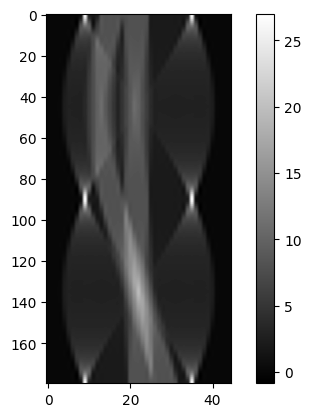

In [99]:
def radonTransform(img: np.ndarray, projs: int, order=3) -> tuple[int, np.ndarray]:
    """
        Faz a transformada de Radon de `img`, para `projs` projeções, com interpolação de ordem `order`.
    """
    
    # Coloca a imagem num contentor
    imgCont = imgContainer(img, margin = max(1, order))

    # Tamanho da imagem
    N = imgCont.shape[0]

    # Ângulos a usar (descartar alpha = 180 pois será igual a alpha = 0)
    aa = np.linspace(0, 180, projs+1)[:-1]

    # Calcular a transformada
    pp = np.zeros((projs, N))

    for index, angle in enumerate(aa):
        # Rodar a imagem
        imgRot = sp.ndimage.rotate(imgCont, angle, reshape=False, order=order)

        # Somar as colunas
        pp[index] = np.sum(imgRot, axis=0)
    
    return img.shape[0], pp


# Calcular a transfomada
projs = 180
Nimg, pp = radonTransform(ff, projs=projs)

# Ver a imagem
plt.imshow(pp, cmap="gray", origin="upper", aspect=0.5)
plt.colorbar()
plt.show()

# Retroprojeção

Vamos fazer a retroprojeção simples espalhando os valores do sinograma de volta para a imagem.

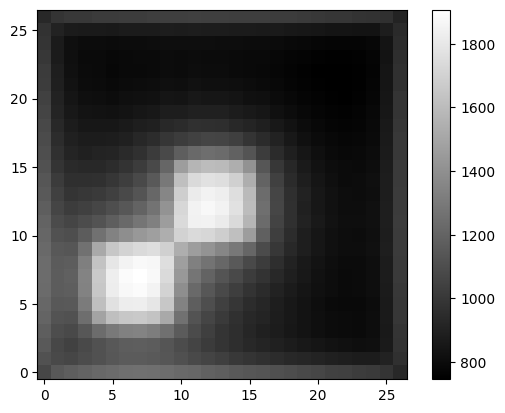

In [100]:
def radonRetro(Nimg: int, sinogram: np.ndarray, order=3) -> np.ndarray:
    """
        Dado o tamanho da imagem `Nimg` e o seu sinograma `sinogram` devolve a sua retroprojeção, selecionando apenas a secção central da imagem de dimensão `Nimg` por `Nimg`.
    """

    # Tamanho da imagem com o contentor
    N = sinogram.shape[1]

    # Array para a imagem
    img = np.zeros((N, N))

    # Ângulos usados
    projs = sinogram.shape[0]
    aa = np.linspace(0, 180, projs+1)[:-1]

    # Ir rodando a imagem e ir somando as linhas do sinograma a todas as suas colunas
    for index, angle in enumerate(aa[:-1]):
        # Linha do sinograma
        pp = sinogram[index]

        # Projetar a linha do sinograma ao longo da imagem
        imgProj = pp * np.ones((N, N))

        # Rodar a projeção de volta para a posição normal
        imgProj = sp.ndimage.rotate(imgProj, -angle, reshape=False, order=order)

        # Somar a projeção ao array inicial
        img += imgProj
    
    margin = (N-Nimg) // 2
    return img[margin:N-margin, margin:N-margin]


# Retroprojeção
rr = radonRetro(Nimg, pp)

# Ver a imagem
plt.imshow(rr, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

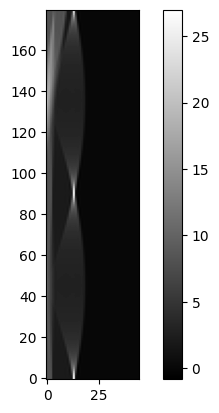

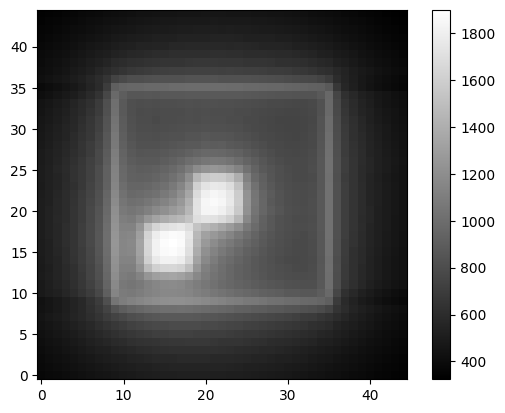

In [108]:
def radonRetroInterpol(Nimg: int, sinogram: np.ndarray, order=3) -> np.ndarray:
    """
        Dado o tamanho da imagem `Nimg` e o seu sinograma `sinogram` devolve a sua retroprojeção, selecionando apenas a secção central da imagem de dimensão `Nimg` por `Nimg`.

        Esta versão usa interpolação pelos valores do sinograma para calcular o integral da retroprojeção.
    """

    # Tamanho da imagem com o contentor
    N = sinogram.shape[1]
    
    # Array para a imagem
    img = np.zeros((N, N))

    # Ângulos usados
    projs = sinogram.shape[0]
    aa = np.linspace(0, 180, projs+1)[:-1]
    ha = aa[1] - aa[0]

    # Interpolação do senograma lembrando que o centro da imagem está em N//2
    mid = N//2
    ppi = sp.interpolate.RectBivariateSpline(aa, np.arange(-mid, mid+1), sinogram)

    pp = ppi(aa, np.arange(N))

    # Ver a imagem
    plt.imshow(pp, cmap="gray", origin="lower")
    plt.colorbar()
    plt.show()

    for x in range(N):
        for y in range(N):
            # Valor de s, lembrando que (x, y) = (N//2, N//2) implica s = 0
            ss = (x - mid) * np.cos(np.radians(aa)) + (y - mid) * np.sin(np.radians(aa))
            ff = np.array(ppi.ev(aa, ss))

            # Avaliar o integral com a regra de Simpson
            img[x, y] = ha * np.sum(ff[:-2:2] + 4 * ff[1:-1:2] + ff[2: :2]) / 3
    
    return img



# Retroprojeção
rr = radonRetroInterpol(Nimg, pp)

# Ver a imagem
plt.imshow(rr, cmap="gray", origin="lower")
plt.colorbar()
plt.show()

# Retroprojeção Filtrada

Vamos agora usar retroprojeção filtrada, usando a FFT para obter o espetro do sinal e lembrando que a frequência associada a um índice é proporcional a esse índice.